In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline  
import emcee
import math
import matplotlib
hfont = {'fontname':'Times New roman'}
mg2color = [107/256.0, 70/256.0, 177/256.0]



   binning by SN   --- human_acceptance_results.fits
   
for all equivalent widths inserted   ---

   minSN    maxSN  inserted_number discovered_number  RATIO_discovered/inserted
   
      0.00000      1.00000        5364      2004.00     0.373601
      1.00000      2.00000         842      395.000     0.469121
      2.00000      3.00000         186      109.000     0.589189
      3.00000      4.00000          86      62.0000     0.720930
      4.00000      5.00000          39      32.0000     0.820512
      5.00000      6.00000          47      45.0000     0.957447
      6.00000      8.00000          48      47.0000     0.979167
      8.00000      10.0000          31      30.0000     0.966774
      10.0000      12.0000          29      27.0000     0.931034
      12.0000      14.0000          18      18.0000      1.00000
      14.0000      18.0000          39      37.0000     0.948718
      18.0000      22.0000          11      11.0000      1.00000
      22.0000      30.0000          23      22.0000     0.956521
      30.0000      38.0000          20      18.0000     0.900000
      38.0000      42.2744           2      2.00000      1.00000

In [2]:
# pass the values to arrays
min_sn = np.array([0.00000, 1.00000, 2.00000, 3.00000, 
          4.00000, 5.00000, 6.00000, 8.00000, 
          10.0000, 12.0000, 14.0000, 18.0000, 22.0000, 30.0000, 38.0000])

max_sn = np.array([1.00000, 2.00000, 3.00000, 4.00000, 
          5.00000, 6.00000, 8.00000, 10.0000, 
          12.0000, 14.0000, 18.0000, 22.0000, 30.0000, 38.0000, 42.2744])

value = np.array([0.373601, 0.469121, 0.589189, 
                  0.720930, 0.820512, 0.957447, 
                  0.979167, 0.966774, 0.931034,  
                  1.00000, 0.948718,  1.00000, 
                  0.956521, 0.900000,  1.00000])

mid_sn = np.array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 7., 9., 11., 13.0, 16.0, 20.0, 26.0, 34.0, 40.0])
fit_mid_sn = np.array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 7., 9., 11., 13.0, 16.0, 20.0, 26.0, 34.0, 40.0, 44.00])


In [3]:
n = np.array([5364, 842, 186,  86,  
              39,  47,  48,  31,  
              29,  18,  39,  11,  
              23,  20,   2])

ns = np.array([2004.00, 395.000, 109.000, 
               62.0000, 32.0000, 45.0000, 
               47.0000, 30.0000, 27.0000, 
               18.0000, 37.0000, 11.0000, 
               22.0000, 18.0000, 2.00000])

nf = n - ns
z = 1.96

error = z*pow(ns*nf/n, 0.5)/100.0
error[np.where(error < 0.1)] = 0.1
error[0] = 0.06443273
error[1] = 0.02938261
error[2] = 0.03166132
print(error)
upper_bound = value + error
lower_bound = value - error
upper_bound[np.where(upper_bound > 1.0)] = 1.0

[ 0.06443273  0.02938261  0.03166132  0.1         0.1         0.1         0.1
  0.1         0.1         0.1         0.1         0.1         0.1         0.1
  0.1       ]


In [4]:
# leave a cell for the fitting process
# exponential function where
# fit_function = p*(1.0 - np.exp(sn/sc))
# p = scalar (0 to 1 in 0.001 steps)
# sn = is the signal to noise (the x axis)
# s = is an exponential scale factor (also to be fit for, (0 to 5, in 0.01 steps), from looking at the distribution)

chi2 =  np.zeros(2000.0*1000.0)
inv_sigma2 =  np.zeros(2000.0*1000.0)
lnlike =  np.zeros(2000.0*1000.0)
ps = np.zeros(2000.0*1000.0)
ss = np.zeros(2000.0*1000.0)


/Users/alex/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/alex/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/alex/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/alex/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/alex/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [19]:
local_counter = 0
yerr = error
y = value
for p in range(0, 1999): 
    local_p = p/1000.0
    for s in range(0, 999):
        local_sc = s/100.0
        model = local_p*(1.0 - np.exp(-mid_sn/local_sc))
        chi2[local_counter] =np.sum((model - y)*(model - y))#/yerr/yerr)
        ps[local_counter] = local_p
        ss[local_counter] = local_sc
        
        inv_sigma2 = 1.0/(yerr**2 + model**2)   
        sigma2 = (yerr**2 + model**2)
        lnlike[local_counter] = -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(6.28*sigma2)))
        
        local_counter = local_counter + 1
        #print(p, sc)
        #plt.plot(mid_sn, local_function, 'b-', lw=0.5, alpha = 0.1)
        




/Users/acodoreanu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide


In [20]:
local_counter = 0
yerr = error
y = value
for p in range(0, 1999): 
    local_p = p/1000.0
    for s in range(0, 999):
        local_sc = s/100.0
        model = local_p*(1.0 - np.exp(-mid_sn/local_sc))
        chi2[local_counter] =np.sum((model - y)*(model - y)/yerr/yerr)
        ps[local_counter] = local_p
        ss[local_counter] = local_sc
        
        inv_sigma2 = 1.0/(yerr**2 + model**2)   
        sigma2 = (yerr**2 + model**2)
        lnlike[local_counter] = -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(6.28*sigma2)))
        
        local_counter = local_counter + 1
        #print(p, sc)
        #plt.plot(mid_sn, local_function, 'b-', lw=0.5, alpha = 0.1)
        





/Users/acodoreanu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide


0.0782748557835
0.811 0.967 1.135
1.51 2.36 3.5


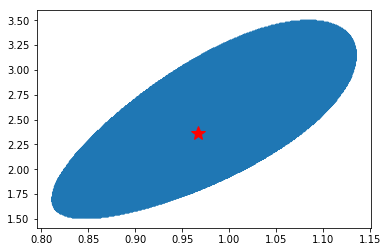

In [21]:
chi2scale = 1./min(chi2[np.where(chi2 > 0)])
chi2_adjusted = chi2[np.where(chi2 > 0)]*chi2scale

best_chi = chi2_adjusted[np.where((chi2_adjusted < 2.706))]
best_ps = ps[np.where((chi2_adjusted < 2.706))]
best_ss = ss[np.where((chi2_adjusted < 2.706))]

pbs = ps[np.where((chi2_adjusted == min(chi2_adjusted)))]
sss = ss[np.where((chi2_adjusted == min(chi2_adjusted)))]

print(chi2scale)
print(min(best_ps), pbs[0], max(best_ps))
print(min(best_ss), sss[0], max(best_ss))

plt.plot(best_ps, best_ss)
plt.plot(pbs, sss, 'r*',markersize=15 )

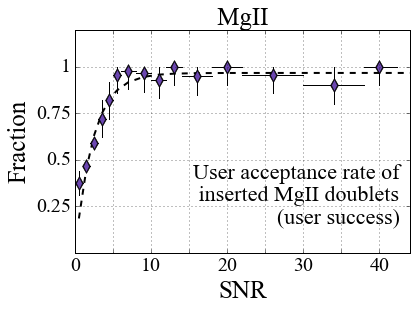

In [10]:
# plot the data

# x, y labels and title
plt.ylabel('Fraction', **hfont,  fontsize=25)
plt.xlabel('SNR', **hfont,  fontsize=25)
plt.title(' MgII ', **hfont,  fontsize=25)

# x and y ranges and scale
plt.xlim([0, 44])
plt.ylim([0,1.2])

# 0.811 0.967 1.135
# 1.51 2.36 3.5
flow = 0.811*(1.0 - np.exp(-fit_mid_sn/3.5))
fhigh = 1.0*(1.0 - np.exp(-fit_mid_sn/1.51))
f  = 0.967*(1.0 - np.exp(-fit_mid_sn/2.36))


# plot the shaded fit 
plt.plot(fit_mid_sn, f, 'k--', lw = 2, alpha = 1)
#plt.fill_between(fit_mid_sn, flow, fhigh, color = 'r', alpha = 0.2)


# x and y ticks
xlabels = ['0', ' ', '10', ' ', '20', ' ', '30', ' ', '40']
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40], 
            xlabels, **hfont, fontsize = 20)
ylabels = [' ', '0.25', '0.5', '0.75', '1']
plt.yticks([0, 0.25, 0.5, 0.75, 1.0], 
            ylabels, **hfont, fontsize = 20)

plt.grid(True)


# plot the vertical error bounds    
for i in range(0, len(min_sn)):
    plt.plot([mid_sn[i], mid_sn[i]], [upper_bound[i], lower_bound[i]], 'k-', lw=1.0)

# plot the bin boundaries
for i in range(0, len(min_sn)):
    plt.plot([min_sn[i], max_sn[i]], [value[i], value[i]], 'k-', lw=1.0)

    
# plot the results
plt.plot(mid_sn, value, 'kd', markersize=10, alpha=1.0)  
plt.plot(mid_sn, value, 'd', markersize=8, color = mg2color, alpha=1.0)   

# output a label
txt = plt.text(15.5, 0.40, "User acceptance rate of", **hfont,  fontsize=22)
txt = plt.text(15.5, 0.28, " inserted MgII doublets", **hfont,  fontsize=22)
txt = plt.text(26.5, 0.16, "(user success)", **hfont,  fontsize=22)


plt.savefig('mg2_acceptance_real.png', bbox_inches='tight', figsize=[24,12], dpi=500)